In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import pathlib
import numpy as np
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
data_dir = pathlib.Path("data")
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.png'))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
image_count = len(list(data_dir.glob('*/*.png')))

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 400
IMG_WIDTH = 400
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)


In [4]:

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


In [96]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(32)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [97]:
full_dataset  = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
#train_ds = prepare_for_training(full_dataset)
#full_dataset = (full_dataset.map(normalize).shuffle(50000).batch(128, drop_remainder=True))#
#
train_dataset = prepare_for_training(full_dataset.take(int(image_count*0.8)))
test_dataset = prepare_for_training(full_dataset.skip(int(image_count*0.8)))

In [98]:
for image, label in train_dataset.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print("Label: ", label.numpy().shape)


Image shape:  (32, 400, 400, 1)
Label:  [[False  True False]
 [False False  True]
 [False False  True]
 [ True False False]
 [False False  True]
 [False  True False]
 [False  True False]
 [ True False False]
 [False  True False]
 [ True False False]
 [ True False False]
 [ True False False]
 [False  True False]
 [False False  True]
 [False False  True]
 [ True False False]
 [ True False False]
 [False  True False]
 [False False  True]
 [False  True False]
 [False False  True]
 [False False  True]
 [False False  True]
 [False False  True]
 [False False  True]
 [False False  True]
 [ True False False]
 [ True False False]
 [False False  True]
 [False  True False]
 [False  True False]
 [False  True False]]
Label:  (32, 3)


In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(8, 3, padding='same', activation='relu', input_shape=(400, 400,1),name="inputlayer"),
    MaxPooling2D(),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(3, activation='softmax', name='output')
])

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer (Conv2D)          (None, 400, 400, 8)       80        
_________________________________________________________________
max_pooling2d_122 (MaxPoolin (None, 200, 200, 8)       0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 200, 200, 16)      1168      
_________________________________________________________________
max_pooling2d_123 (MaxPoolin (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_124 (MaxPoolin (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 50, 50, 64)      

In [112]:
model.compile(
        optimizer='adam',
        loss=['categorical_crossentropy'],
        metrics=['accuracy']
    )

In [113]:
history=model.fit(train_dataset,epochs=10,validation_data=test_dataset,steps_per_epoch=5,validation_steps=5)

Train for 5 steps, validate for 5 steps
Epoch 1/10
5/5 [==============================] - 16s 3s/step - loss: 1.0970 - accuracy: 0.2875 - val_loss: 1.0911 - val_accuracy: 0.4688
Epoch 2/10
5/5 [==============================] - 16s 3s/step - loss: 1.0684 - accuracy: 0.3125 - val_loss: 0.9910 - val_accuracy: 0.3562
Epoch 3/10
5/5 [==============================] - 16s 3s/step - loss: 0.8765 - accuracy: 0.5813 - val_loss: 0.6268 - val_accuracy: 0.7312
Epoch 4/10
5/5 [==============================] - 16s 3s/step - loss: 0.6046 - accuracy: 0.7812 - val_loss: 0.3830 - val_accuracy: 0.6375
Epoch 5/10
5/5 [==============================] - 16s 3s/step - loss: 0.3764 - accuracy: 0.7625 - val_loss: 0.6102 - val_accuracy: 0.6125
Epoch 6/10
5/5 [==============================] - 16s 3s/step - loss: 0.4690 - accuracy: 0.7000 - val_loss: 0.3286 - val_accuracy: 0.7437
Epoch 7/10
5/5 [==============================] - 17s 3s/step - loss: 0.3575 - accuracy: 0.8500 - val_loss: 0.2287 - val_accuracy: 0

In [ ]:
training_loss

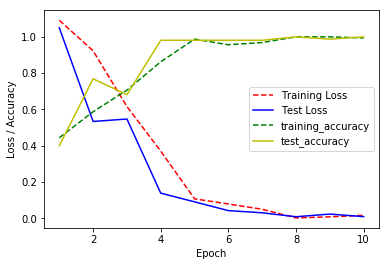

In [109]:

# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.plot(epoch_count, training_accuracy, 'g--')
plt.plot(epoch_count, test_accuracy, 'y-')
plt.legend(['Training Loss', 'Test Loss','training_accuracy','test_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.show();

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           )
